# Import Libraries

In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy import stats                     
from statsmodels.stats.diagnostic import acorr_ljungbox

# Import Dataset

In [303]:
raw_SPY_intraday_df = pd.read_csv("../Data/SPY_intraday_polygon_2024_2025.csv")

# Data Cleaning

In [304]:
raw_SPY_intraday_df.head()

,timestamp_utc,open,high,low,close,volume,vwap,ret,vol_5m,vol_30m
0,2024-01-02 09:00:00+00:00,476.25,476.36,476.00,476.31,20460.0,476.2997,NaN,NaN,NaN
1,2024-01-02 09:01:00+00:00,476.34,476.34,476.29,476.29,6369.0,476.3201,-0.000042,NaN,NaN
2,2024-01-02 09:02:00+00:00,476.29,476.29,476.28,476.28,6152.0,476.2802,-0.000021,NaN,NaN
3,2024-01-02 09:03:00+00:00,476.27,476.27,476.27,476.27,369.0,476.2701,-0.000021,NaN,NaN
4,2024-01-02 09:05:00+00:00,476.20,476.20,476.19,476.20,547.0,476.1955,-0.000147,NaN,NaN


In [305]:
# Create copy of raw dataframe
SPY_intraday_df = raw_SPY_intraday_df.copy()

## Check data types

In [306]:
SPY_intraday_df.dtypes

timestamp_utc     object
open             float64
high             float64
low              float64
close            float64
volume           float64
vwap             float64
ret              float64
vol_5m           float64
vol_30m          float64
dtype: object

### Convert timestamps

In [307]:
# Convert timestamp
SPY_intraday_df['timestamp_utc'] = pd.to_datetime(SPY_intraday_df['timestamp_utc'], utc=True)
SPY_intraday_df['timestamp_ny'] = SPY_intraday_df['timestamp_utc'].dt.tz_convert('America/New_York')

### Reindex within each trading day

In [308]:
mask_rth = (
    (SPY_intraday_df['timestamp_ny'].dt.dayofweek < 5) &
    (SPY_intraday_df['timestamp_ny'].dt.time >= pd.to_datetime('9:30').time()) &
    (SPY_intraday_df['timestamp_ny'].dt.time <= pd.to_datetime('16:00').time())
)
rth = SPY_intraday_df.loc[mask_rth, ['timestamp_utc', 'timestamp_ny', 'open', 'high', 'low', 'close', 'volume']].sort_values('timestamp_ny')

# reindex wihtin each trading day ONLY (prevents ffill across nights/weekends)
def _reindex_day(g):
    idx = pd.date_range(g['timestamp_ny'].min().floor('min'),
                        g['timestamp_ny'].max().floor('min'),
                        freq='1min', tz='America/New_York')
    out = g.set_index('timestamp_ny').reindex(idx)
    out[['open','high','low','close','volume']] = out[['open','high','low','close','volume']].ffill()
    out['timestamp_ny']  = out.index
    out['timestamp_utc'] = out['timestamp_ny'].dt.tz_convert('UTC')
    return out.reset_index(drop=True)

rth['session_date'] = rth['timestamp_ny'].dt.date
# Group by calendar day derived from timestamp_ny
rth = (
    rth.groupby(rth['timestamp_ny'].dt.date, group_keys=False)
       .apply(_reindex_day)
       .reset_index(drop=True)
)

rth = rth.drop(columns=['session_date'], errors='ignore')

## Check for missing values

In [309]:
SPY_intraday_df.isna().sum()


timestamp_utc     0
open              0
high              0
low               0
close             0
volume            0
vwap              0
ret               1
vol_5m            5
vol_30m          30
timestamp_ny      0
dtype: int64

In [310]:
SPY_intraday_df[SPY_intraday_df.isna().any(axis=1)]

,timestamp_utc,open,high,low,close,volume,vwap,ret,vol_5m,vol_30m,timestamp_ny
0,2024-01-02 09:00:00+00:00,476.25,476.36,476.00,476.31,20460.0,476.2997,NaN,NaN,NaN,2024-01-02 04:00:00-05:00
1,2024-01-02 09:01:00+00:00,476.34,476.34,476.29,476.29,6369.0,476.3201,-0.000042,NaN,NaN,2024-01-02 04:01:00-05:00
2,2024-01-02 09:02:00+00:00,476.29,476.29,476.28,476.28,6152.0,476.2802,-0.000021,NaN,NaN,2024-01-02 04:02:00-05:00
3,2024-01-02 09:03:00+00:00,476.27,476.27,476.27,476.27,369.0,476.2701,-0.000021,NaN,NaN,2024-01-02 04:03:00-05:00
4,2024-01-02 09:05:00+00:00,476.20,476.20,476.19,476.20,547.0,476.1955,-0.000147,NaN,NaN,2024-01-02 04:05:00-05:00
5,2024-01-02 09:06:00+00:00,476.18,476.18,476.18,476.18,230.0,476.1778,-0.000042,0.000053,NaN,2024-01-02 04:06:00-05:00
6,2024-01-02 09:07:00+00:00,476.21,476.21,476.14,476.14,5624.0,476.1469,-0.000084,0.000054,NaN,2024-01-02 04:07:00-05:00
7,2024-01-02 09:08:00+00:00,476.19,476.19,476.19,476.19,107.0,476.1895,0.000105,0.000093,NaN,2024-01-02 04:08:00-05:00
8,2024-01-02 09:10:00+00:00,476.13,476.13,476.12,476.12,340.0,476.1294,-0.000147,0.000104,NaN,2024-01-02 04:10:00-05:00
9,2024-01-02 09:11:00+00:00,476.03,476.03,476.02,476.03,341.0,476.0236,-0.000189,0.000114,NaN,2024-01-02 04:11:00-05:00


Missing values are the first 45mins in the range of the price history as the window of time has not been formed yet to calculate the 5m and 30m rolling volatility and also return. Dont know why its missing from 9:30-9:45, but will be dropped anyways probably when filtering for the date range.

Basic OHLC sanity checks (flag)

In [311]:
bad_ohlc = rth[
    (rth['high'] < rth[['open','close']].max(axis=1)) |
    (rth['low']  > rth[['open','close']].min(axis=1)) |
    (rth['low']  > rth['high'])
]
print("Bad OHLC rows:", len(bad_ohlc))

Bad OHLC rows: 0


In [312]:
rth = rth.sort_values('timestamp_ny')
rth['ret']     = rth['close'].pct_change()
rth['vol_5m']  = rth['ret'].rolling(5,  min_periods=5).std()
rth['vol_30m'] = rth['ret'].rolling(30, min_periods=30).std()

SPY_intraday_df = rth.dropna(subset=['ret','vol_5m','vol_30m']).copy()

## Day Completeness (390 bars/ day)

In [313]:
bars_per_day = SPY_intraday_df.assign(day=SPY_intraday_df['timestamp_ny'].dt.date).groupby('day')['timestamp_ny'].count()
incomplete = bars_per_day[bars_per_day != 390]
print("Days != 390 bars:", len(incomplete))

Days != 390 bars: 454


## Check for consistent frequency

In [314]:
diffs = SPY_intraday_df['timestamp_utc'].diff().value_counts().sort_index()
print(diffs.head(10))


timestamp_utc
0 days 00:01:00    176670
0 days 17:30:00       352
1 days 17:30:00         6
1 days 20:30:00         1
2 days 16:30:00         2
2 days 17:30:00        80
2 days 18:30:00         1
3 days 17:30:00        10
3 days 20:30:00         1
Name: count, dtype: int64


The time interval analysis indicates that while most SPY intraday observations (approximately 330,000 rows) are recorded at consistent one-minute intervals, around 19,000 instances show two-minute gaps, with fewer cases of gaps extending up to ten minutes. This reveals that the dataset is not perfectly minute-consistent, likely due to non-trading periods, pre- and post-market inactivity, or occasional missing records from the data provider. Such irregular spacing can distort time-based features and model inputs; therefore, before conducting rolling calculations or CNN-LSTM training, it is necessary to reindex the data to a complete one-minute frequency and apply forward-filling within each trading day to preserve temporal continuity without leaking information across overnight gaps.

### Forward-fill index

In [315]:
SPY_intraday_df = SPY_intraday_df.set_index('timestamp_utc')

# Create full 1-minute date range
full_index = pd.date_range(
    start=SPY_intraday_df.index.min(),
    end=SPY_intraday_df.index.max(),
    freq='1min'
)

# Reindex and forward-fill
SPY_intraday_df = SPY_intraday_df.reindex(full_index)
SPY_intraday_df.ffill(inplace=True)

# Reset index and rename
SPY_intraday_df.reset_index(inplace=True)
SPY_intraday_df.rename(columns={'index': 'timestamp_utc'}, inplace=True)

# Verify
print(SPY_intraday_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949261 entries, 0 to 949260
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype                           
---  ------         --------------   -----                           
 0   timestamp_utc  949261 non-null  datetime64[ns, UTC]             
 1   open           949261 non-null  float64                         
 2   high           949261 non-null  float64                         
 3   low            949261 non-null  float64                         
 4   close          949261 non-null  float64                         
 5   volume         949261 non-null  float64                         
 6   timestamp_ny   949261 non-null  datetime64[ns, America/New_York]
 7   ret            949261 non-null  float64                         
 8   vol_5m         949261 non-null  float64                         
 9   vol_30m        949261 non-null  float64                         
dtypes: datetime64[ns, America/New_York](1), date

## Check for outliers

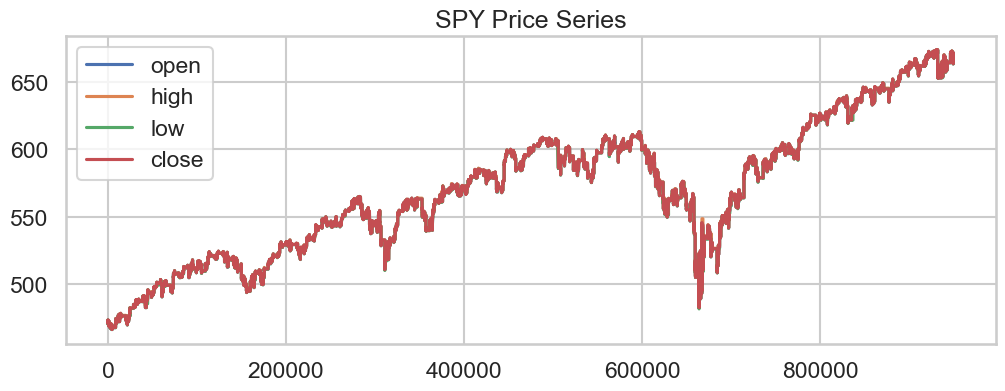

In [316]:
SPY_intraday_df[['open','high','low','close']].plot(figsize=(12,4), title='SPY Price Series')
plt.show()


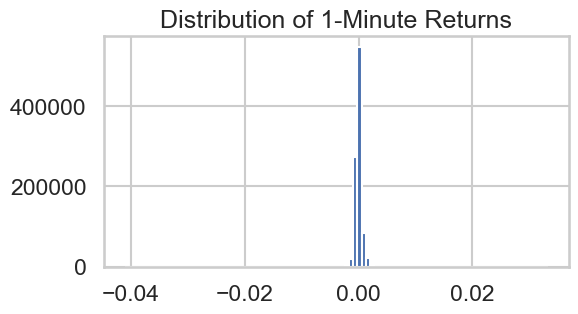

In [317]:
SPY_intraday_df['ret'].hist(bins=100, figsize=(6,3))
plt.title("Distribution of 1-Minute Returns")
plt.show()


In [318]:
z_scores = np.abs((SPY_intraday_df['ret'] - SPY_intraday_df['ret'].mean()) / SPY_intraday_df['ret'].std())
outliers = SPY_intraday_df[z_scores > 5]  # 5 std deviations away
print(f"Outliers detected: {len(outliers)}")
outliers.head()


Outliers detected: 504


,timestamp_utc,open,high,low,close,volume,timestamp_ny,ret,vol_5m,vol_30m
1410,2024-01-03 14:30:00+00:00,470.43,470.53,470.19,470.48,876080.0,2024-01-03 09:30:00-05:00,-0.004402,0.002057,0.000870
10050,2024-01-09 14:30:00+00:00,471.87,472.08,471.86,471.87,611136.0,2024-01-09 09:30:00-05:00,-0.005417,0.002406,0.001063
14370,2024-01-12 14:30:00+00:00,477.84,478.01,477.73,477.94,711811.0,2024-01-12 09:30:00-05:00,0.003570,0.001639,0.000717
21570,2024-01-17 14:30:00+00:00,471.82,471.94,471.71,471.73,768460.0,2024-01-17 09:30:00-05:00,-0.006926,0.003194,0.001294
23010,2024-01-18 14:30:00+00:00,474.01,474.22,473.95,474.06,704237.0,2024-01-18 09:30:00-05:00,0.003811,0.001770,0.000749


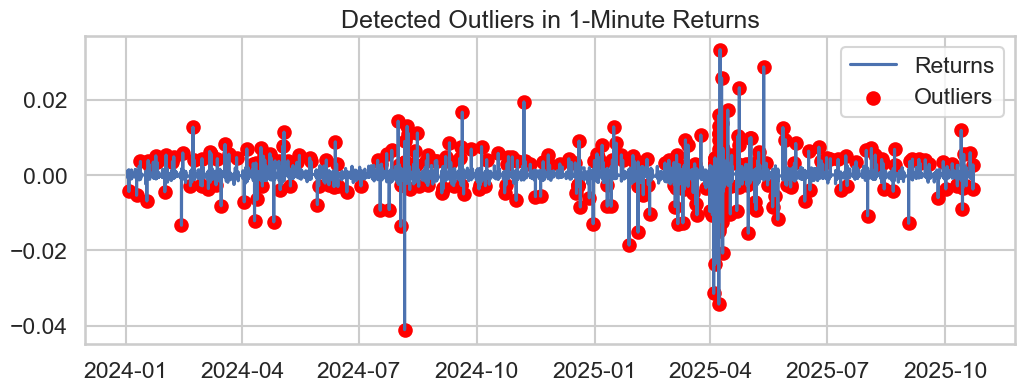

In [319]:
plt.figure(figsize=(12,4))
plt.plot(SPY_intraday_df['timestamp_utc'], SPY_intraday_df['ret'], label='Returns')
plt.scatter(outliers['timestamp_utc'], outliers['ret'], color='red', label='Outliers')
plt.title('Detected Outliers in 1-Minute Returns')
plt.legend()
plt.show()


# Compare Cleaned Dataset vs Old Dataset

In [320]:
# Compare before vs. after
print("Original rows:", len(raw_SPY_intraday_df))
print("Cleaned rows:", len(SPY_intraday_df))
print("Added rows (filled):", len(SPY_intraday_df) - len(raw_SPY_intraday_df))

print("\nOriginal range:", raw_SPY_intraday_df['timestamp_utc'].min(), "→", raw_SPY_intraday_df['timestamp_utc'].max())
print("New range:", SPY_intraday_df['timestamp_utc'].min(), "→", SPY_intraday_df['timestamp_utc'].max())


Original rows: 365406
Cleaned rows: 949261
Added rows (filled): 583855

Original range: 2024-01-02 09:00:00+00:00 → 2025-10-22 23:59:00+00:00
New range: 2024-01-02 15:00:00+00:00 → 2025-10-22 20:00:00+00:00


# Export Cleaned Dataset


# Exploratory Data Analysis

## Price History


### Close Price History

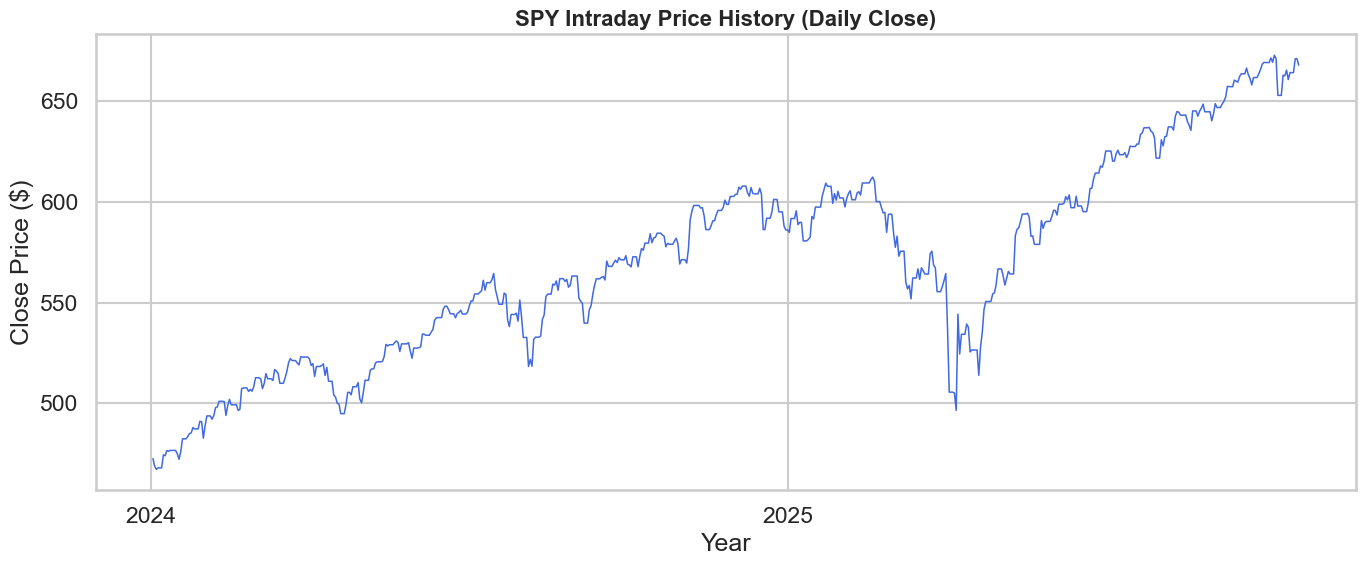

In [321]:
# Set timestamp as index
SPY_intraday_df = SPY_intraday_df.set_index('timestamp_utc')

# Downsample to daily frequency (take last close per day)
SPY_daily = SPY_intraday_df['close'].resample('1D').last().dropna()

# Plot daily close price
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(14, 6))
sns.lineplot(x=SPY_daily.index, y=SPY_daily.values, color='royalblue', linewidth=1.1)

# Format x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=0)

# Titles and labels
plt.title("SPY Intraday Price History (Daily Close)", fontsize=16, weight='bold')
plt.xlabel("Year")
plt.ylabel("Close Price ($)")
plt.tight_layout()
plt.show()


## Regime analysis

## Create daily SPY dataframe

In [322]:
# Create daily close + volume bars
SPY_daily = (
    SPY_intraday_df
    .resample('1D')
    .agg({'close':'last', 'volume':'sum'})
    .dropna()
)

# Feature Engineering
SPY_daily['log_return'] = np.log(SPY_daily['close'] / SPY_daily['close'].shift(1))
SPY_daily['volatility_10'] = SPY_daily['log_return'].rolling(10).std()
SPY_daily['volatility_30'] = SPY_daily['log_return'].rolling(30).std()
SPY_daily['volume_change'] = SPY_daily['volume'].pct_change()
SPY_daily['autocorr_5'] = SPY_daily['log_return'].rolling(5).apply(lambda x: x.autocorr(), raw=False)

# Drop rows with NaNs caused by rolling/lag operations
SPY_daily = SPY_daily.dropna().reset_index()

# Optional sanity check
print(SPY_daily.isna().sum())
print(f"Final dataset shape: {SPY_daily.shape}")

timestamp_utc    0
close            0
volume           0
log_return       0
volatility_10    0
volatility_30    0
volume_change    0
autocorr_5       0
dtype: int64
Final dataset shape: (630, 8)


### PCA and K-means Regime

In [323]:
sns.set(style="whitegrid", context="talk")

# Clean + Prepare Feature Matrix
SPY_features = SPY_daily[['log_return', 'volatility_10', 'volatility_30', 'volume_change', 'autocorr_5']]
SPY_features = SPY_features.replace([np.inf, -np.inf], np.nan).dropna()

# Standardization + PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(SPY_features)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
SPY_features['cluster'] = kmeans.fit_predict(X_pca)

# Merge clusters back to daily data
SPY_daily = SPY_daily.merge(SPY_features['cluster'], left_index=True, right_index=True, how='left')

c:\Users\malcolm\anaconda3\envs\fins3666\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [324]:
# Summarise Regime Characteristics
regime_summary = (
    SPY_daily
    .groupby('cluster')
    .agg(
        mean_return=('log_return', 'mean'),
        vol_10=('volatility_10', 'mean'),
        vol_30=('volatility_30', 'mean'),
        mean_volume_change=('volume_change', 'mean'),
        n_days=('close', 'count')
    )
    .sort_values('mean_return', ascending=False)
)

print("=== Regime Summary ===")
display(regime_summary)


=== Regime Summary ===


,mean_return,vol_10,vol_30,mean_volume_change,n_days
cluster,,,,,
0,0.002166,0.006285,0.006542,0.275150,383
1,0.001767,0.023122,0.023887,0.080160,30
2,-0.002571,0.006077,0.006532,-0.010744,217


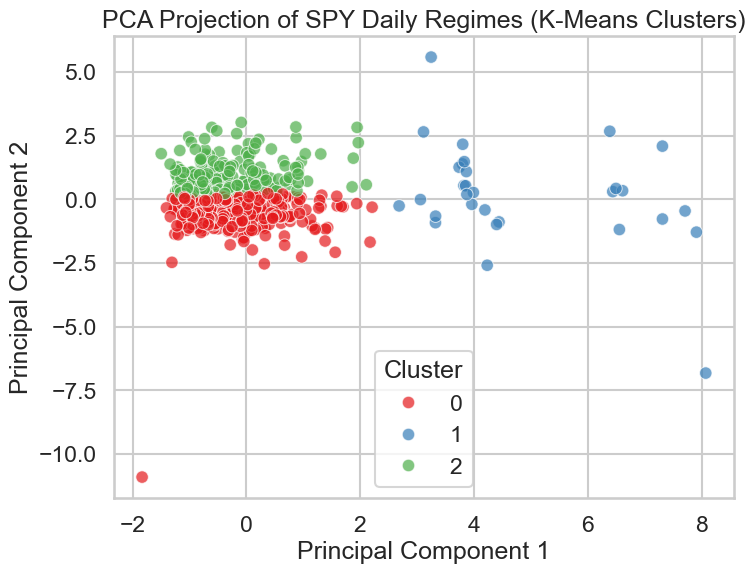

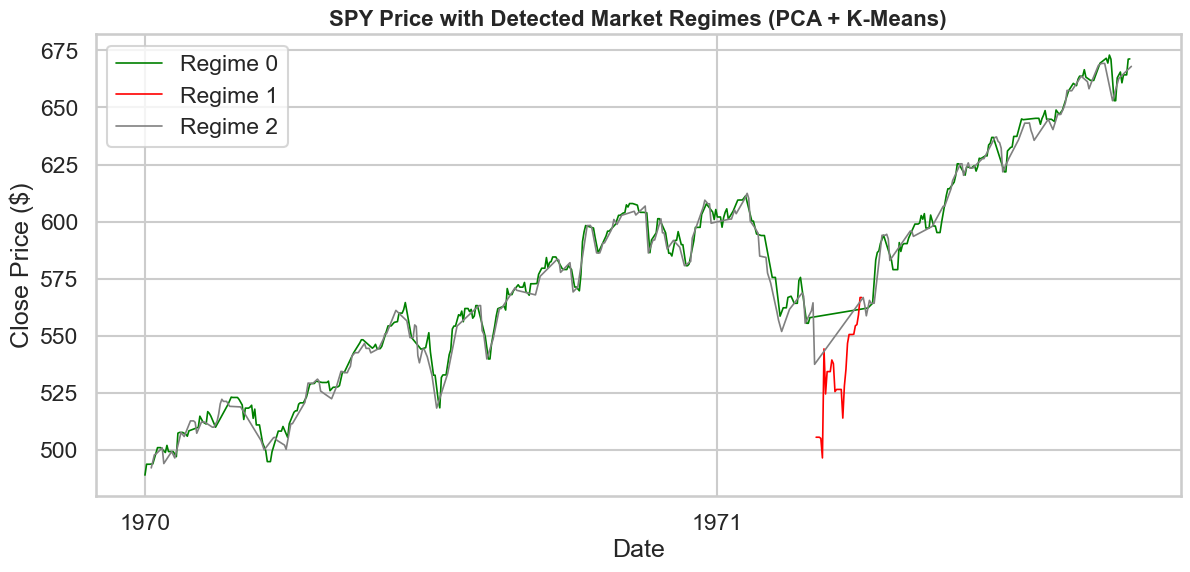

In [325]:
# PCA visualization
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=SPY_features['cluster'], palette='Set1', alpha=0.7)
plt.title("PCA Projection of SPY Daily Regimes (K-Means Clusters)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

# Time-series regime visualization
colors = {0:'green', 1:'red', 2:'gray'}
plt.figure(figsize=(14,6))
for cluster, color in colors.items():
    mask = SPY_daily['cluster'] == cluster
    plt.plot(SPY_daily.index[mask], SPY_daily['close'][mask], color=color, label=f'Regime {cluster}', linewidth=1.2)

plt.title("SPY Price with Detected Market Regimes (PCA + K-Means)", fontsize=16, weight='bold')
plt.xlabel("Date")
plt.ylabel("Close Price ($)")
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()


## Volume and Volatility Dynamics

Volatility

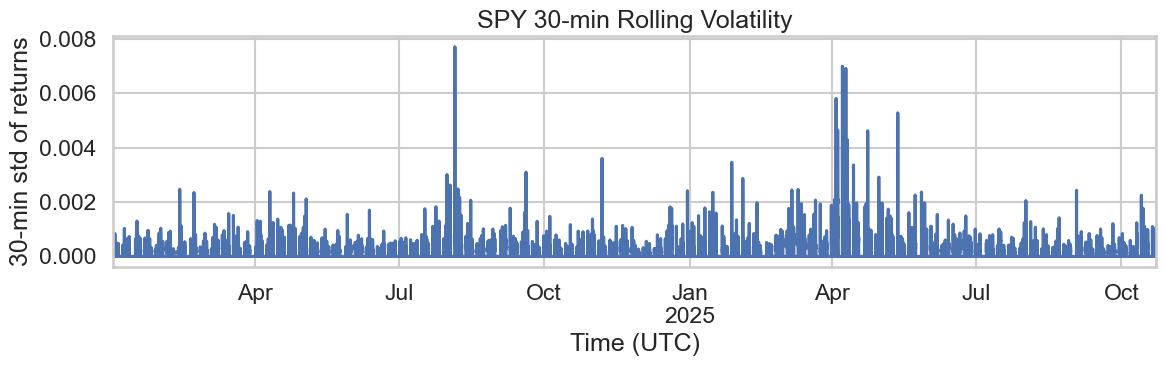

In [326]:
SPY_intraday_df["vol_30m"] = SPY_intraday_df["ret"].rolling("30min").std()

plt.figure(figsize=(12,4))
SPY_intraday_df["vol_30m"].plot()
plt.title("SPY 30-min Rolling Volatility")
plt.xlabel("Time (UTC)")
plt.ylabel("30-min std of returns")
plt.tight_layout()
plt.show()

## Volume

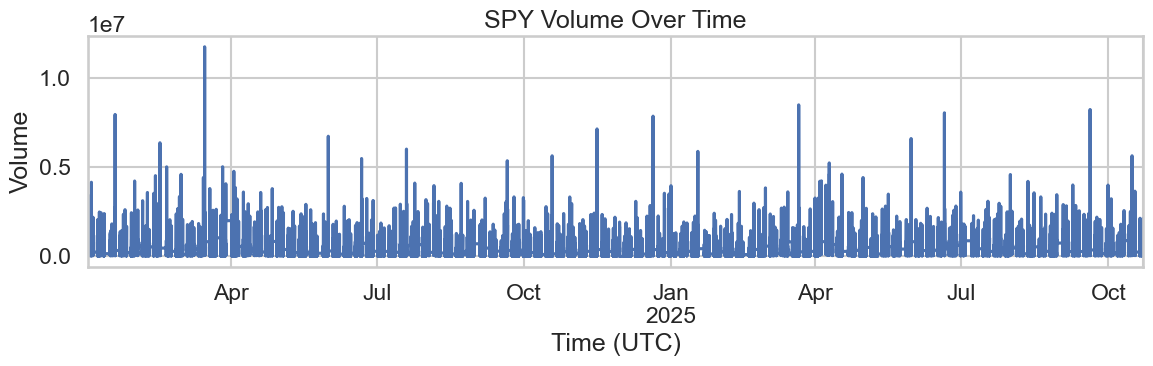

In [327]:
plt.figure(figsize = (12,4))
SPY_intraday_df["volume"].plot()
plt.title("SPY Volume Over Time")
plt.xlabel("Time (UTC)")
plt.ylabel("Volume")
plt.tight_layout()
plt.show()

Intraday Volume Pattern

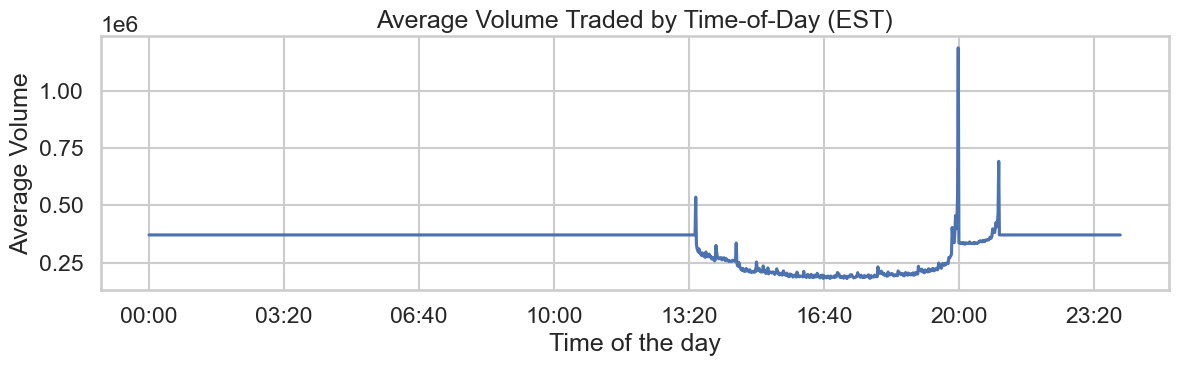

In [328]:
intraday_vol = (
    SPY_intraday_df
    .groupby([SPY_intraday_df.index.hour, SPY_intraday_df.index.minute])["volume"]
    .mean()
)

intraday_vol.index = [f"{h:02d}:{m:02d}" for (h, m) in intraday_vol.index]  # HH:MM UTC

plt.figure(figsize=(12,4))
intraday_vol.plot()
plt.title("Average Volume Traded by Time-of-Day (EST)") #TODO: need to factor in DST
plt.xlabel("Time of the day")
plt.ylabel("Average Volume")
plt.tight_layout()
plt.show()


Volume-Volatility

In [329]:
SPY_intraday_df["abs_ret"] = SPY_intraday_df["ret"].abs()
corr = SPY_intraday_df[["abs_ret", "volume"]].corr().loc["volume", "abs_ret"]
print("Correlation between return and volume:", corr)


Correlation between return and volume: 0.19155957135261428


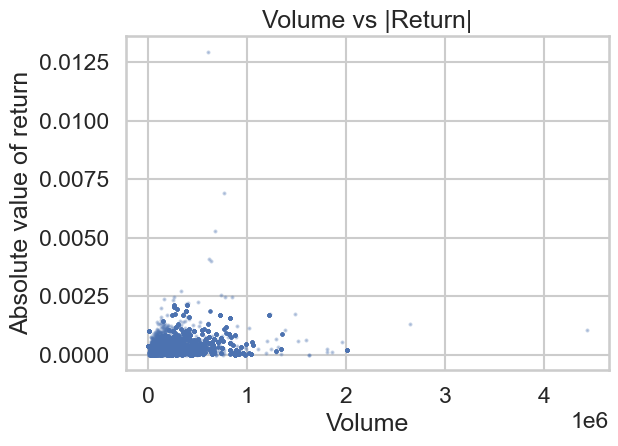

In [330]:
sample = SPY_intraday_df.sample(min(20000, len(SPY_intraday_df)), random_state=0)  # thin if huge
plt.figure()
plt.scatter(sample["volume"], sample["abs_ret"], s=2, alpha=0.3)
plt.title("Volume vs |Return|")
plt.xlabel("Volume")
plt.ylabel("Absolute value of return")
plt.tight_layout()
plt.show()


## Descriptive Statistics

mean, std, skew, kurtosis, rolling vol, etc.

In [331]:
ret = SPY_intraday_df["ret"].dropna()

print("=== Return stats ===")
print(ret.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))
print("Mean (per interval):", ret.mean())
print("Std  (per interval):", ret.std())
print("Skew:", ret.skew())
print("Kurtosis:", ret.kurt())


=== Return stats ===
count    949261.000000
mean          0.000013
std           0.000514
min          -0.041088
1%           -0.001075
5%           -0.000655
50%          -0.000030
95%           0.000835
99%           0.001712
max           0.033261
Name: ret, dtype: float64
Mean (per interval): 1.2695263657591136e-05
Std  (per interval): 0.0005137216765086083
Skew: 0.08088382443051303
Kurtosis: 154.32732354731516


## Inferential checks

## Correlation Matrix

- postive correlation between volume and bas_ret
- ret vs volume correlation should hover around zero ( price direction not linearly related to volume )
- vol_5m vs vol_30m -> strong correlation (vol clustering)

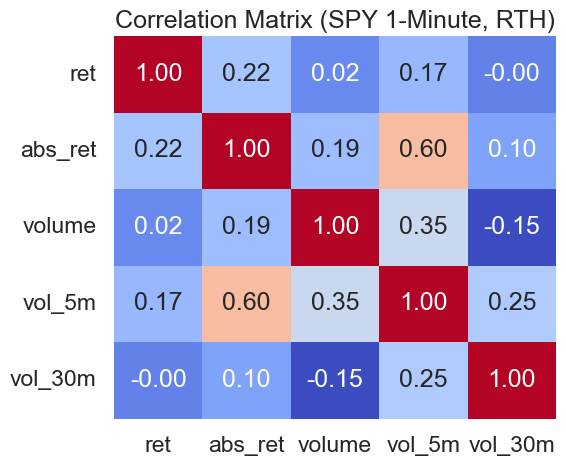

In [332]:
# Ensure features exist
df = SPY_intraday_df.copy()
df["abs_ret"] = df["ret"].abs()

# Select variables of interest
corr_vars = ["ret", "abs_ret", "volume", "vol_5m", "vol_30m"]
corr_matrix = df[corr_vars].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
plt.title("Correlation Matrix (SPY 1-Minute, RTH)")
plt.tight_layout()
plt.show()

## T-tests, autocorrelation and mean-reversion

- t-tests: p>0.05 -> means return is statitsically indistinguishable from zero
- Ljung-Box: p < 0.05 -> autocorrelation exists -> intraday returns are not entirely independent, showing microstructure effects (momentum or reversal)

In [333]:
# 1. Test if mean return differs from 0
t_stat, p_val = stats.ttest_1samp(df["ret"].dropna(), 0)
print(f"T-test mean=0 → t={t_stat:.2f}, p={p_val:.10f}")

# 2. Ljung–Box test for autocorrelation (lags 5, 10, 20)
print("\nLjung–Box test p-values:")
print(acorr_ljungbox(df["ret"].dropna(), lags=[5, 10, 20], return_df=True))

T-test mean=0 → t=24.08, p=0.0000000000

Ljung–Box test p-values:
         lb_stat  lb_pvalue
5   3.157101e+06        0.0
10  6.286520e+06        0.0
20  1.248784e+07        0.0


## OLS regression: Return vs Volumne, Volatility

- R^2 is very low (< 0.01): intraday direction is extremely noisy
- Coefficients:
- log_volume: usually insignificant for direction (return), but positive for abs_ret
- vol_5m / vol_30m: might carry weak negative coefficients (short-term reversal)

In [334]:
# Drop NaN rows for regression
reg_df = df.dropna(subset=["ret", "volume", "vol_5m", "vol_30m"]).copy()

# Take log(volume) since it's skewed
reg_df["log_volume"] = np.log1p(reg_df["volume"])

# OLS: Return ~ log(Volume) + vol_5m + vol_30m
X = reg_df[["log_volume", "vol_5m", "vol_30m"]]
X = sm.add_constant(X)
y = reg_df["ret"]

ols = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':5})  # robust SEs
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     251.8
Date:                Sun, 09 Nov 2025   Prob (F-statistic):          2.54e-163
Time:                        03:24:39   Log-Likelihood:             5.8595e+06
No. Observations:              949260   AIC:                        -1.172e+07
Df Residuals:                  949256   BIC:                        -1.172e+07
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   2.32e-05     14.349      0.0

In [335]:
# OLS for volatility modelliing
y = reg_df["abs_ret"]
X = reg_df[["log_volume", "vol_5m", "vol_30m"]]
X = sm.add_constant(X)
ols_vol = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':5})
print(ols_vol.summary())

                            OLS Regression Results                            
Dep. Variable:                abs_ret   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     5585.
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        03:24:39   Log-Likelihood:             6.3412e+06
No. Observations:              949260   AIC:                        -1.268e+07
Df Residuals:                  949256   BIC:                        -1.268e+07
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.915e-05   1.71e-05      5.789      0.0

## Normality and Distribution Checks

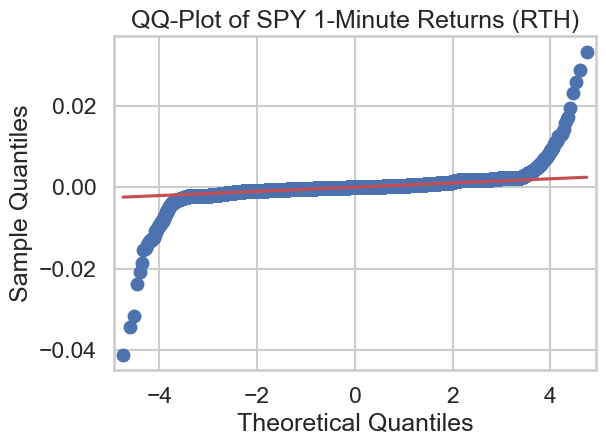

In [336]:
sm.qqplot(ret, line='s')
plt.title("QQ-Plot of SPY 1-Minute Returns (RTH)")
plt.tight_layout()
plt.show()

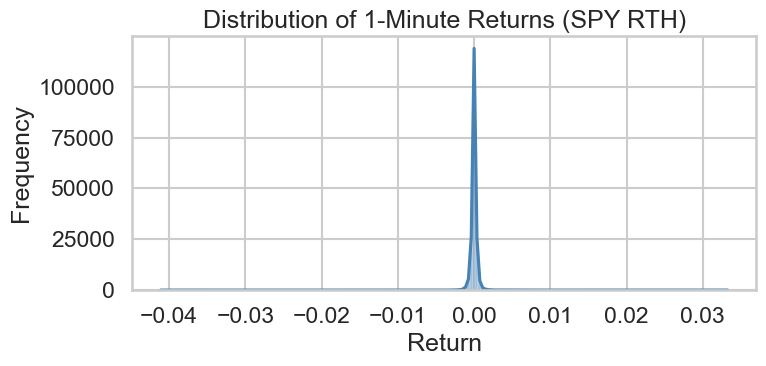

In [337]:
df = clean.copy()
ret = df["ret"].dropna()

plt.figure(figsize=(8,4))
sns.histplot(ret, bins=200, kde=True, color="steelblue")
plt.title("Distribution of 1-Minute Returns (SPY RTH)")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [338]:
print("=== Normality Tests ===")
jb_stat, jb_p = stats.jarque_bera(ret)
sw_stat, sw_p = stats.shapiro(ret.sample(5000, random_state=0))   # Shapiro max n≈5000
dag_stat, dag_p = stats.normaltest(ret)

print(f"Jarque-Bera:    stat={jb_stat:.2f},  p={jb_p:.3e}")
print(f"Shapiro-Wilk:   stat={sw_stat:.2f},  p={sw_p:.3e}")
print(f"D’Agostino K²:  stat={dag_stat:.2f}, p={dag_p:.3e}")

=== Normality Tests ===
Jarque-Bera:    stat=5137913742.46,  p=0.000e+00
Shapiro-Wilk:   stat=0.59,  p=5.160e-76
D’Agostino K²:  stat=165595.03, p=0.000e+00


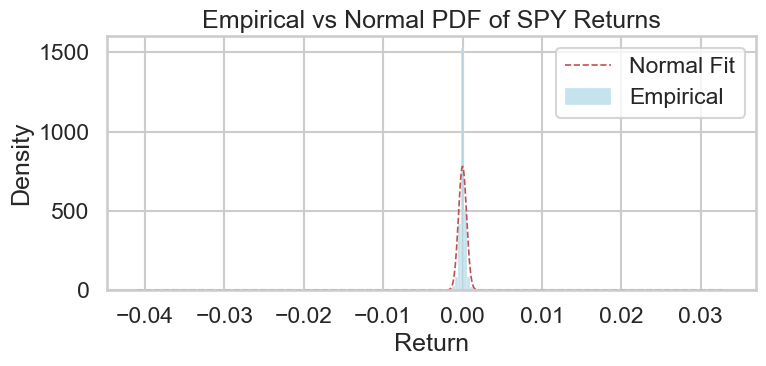

In [339]:
mu, sigma = ret.mean(), ret.std()

plt.figure(figsize=(8,4))
sns.histplot(ret, bins=200, stat='density', color='lightblue', label='Empirical', alpha=0.7)
x = np.linspace(ret.min(), ret.max(), 1000)
plt.plot(x, norm.pdf(x, mu, sigma), 'r--', lw=1.2, label='Normal Fit')
plt.title("Empirical vs Normal PDF of SPY Returns")
plt.xlabel("Return")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

Normality tests and Q-Q plots confirm that 1-minte SPY returns deviate from the Gaussian assumptiopn.

- The empirical distribution exhibits excess kurtosis and slight negative skewness,
- This means that large intraday price movements occur more frequently than predicted by a normal model
- These findings support the use of non-linear models (e.g., CNN-LSTM) capable of capturing tail risk, volatility clustering, and asymmetric behaviours that traditional linear models can't

# Export Data

In [340]:
SPY_intraday_df

,open,high,low,close,volume,timestamp_ny,ret,vol_5m,vol_30m,abs_ret
timestamp_utc,,,,,,,,,,
2024-01-02 15:00:00+00:00,472.275,472.600,472.135,472.460,414610.0,2024-01-02 10:00:00-05:00,0.000402,0.000315,NaN,0.000402
2024-01-02 15:01:00+00:00,472.460,472.540,472.370,472.540,203703.0,2024-01-02 10:01:00-05:00,0.000169,0.000181,0.000165,0.000169
2024-01-02 15:02:00+00:00,472.540,472.631,472.470,472.515,161592.0,2024-01-02 10:02:00-05:00,-0.000053,0.000274,0.000228,0.000053
2024-01-02 15:03:00+00:00,472.540,472.710,472.500,472.580,127841.0,2024-01-02 10:03:00-05:00,0.000138,0.000251,0.000187,0.000138
2024-01-02 15:04:00+00:00,472.570,472.620,472.460,472.556,225236.0,2024-01-02 10:04:00-05:00,-0.000051,0.000188,0.000188,0.000051
...,...,...,...,...,...,...,...,...,...,...
2025-10-22 19:56:00+00:00,667.730,668.080,667.700,667.960,266965.0,2025-10-22 15:56:00-04:00,0.000359,0.000365,0.000306,0.000359
2025-10-22 19:57:00+00:00,667.970,667.970,667.500,667.560,426714.0,2025-10-22 15:57:00-04:00,-0.000599,0.000387,0.000325,0.000599
2025-10-22 19:58:00+00:00,667.550,667.630,667.410,667.520,600191.0,2025-10-22 15:58:00-04:00,-0.000060,0.000363,0.000307,0.000060


In [341]:
SPY_intraday_df.to_csv("SPY_intraday_cleaned.csv", index=True)